In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#from dask import dataframe as dd

sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [2]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


### Load in the data

In [3]:
## Read in 2018 -2022 data from filesystem in chunks
chunks_df_flights =[]
count = 0
with pd.read_csv("../../data/eda/flights/all_flight_data_20182022/all_flight_data_20182022.zip",  chunksize=1000000, low_memory=False, index_col=False) as chunk_df_flights20182022:
    for chunk in chunk_df_flights20182022:
        chunks_df_flights.append(chunk)
        count = count + 1
        print(count)
        if count == 5:
            break

1
2
3
4
5


In [4]:
df_flights = pd.concat(chunks_df_flights, ignore_index=True)

In [5]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Columns: 121 entries, Unnamed: 0 to Unnamed: 119
dtypes: float64(73), int64(23), object(25)
memory usage: 4.5+ GB


In [6]:
df_flights.tail()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Originally_Scheduled_Code_Share_Airline,DOT_ID_Originally_Scheduled_Code_Share_Airline,IATA_Code_Originally_Scheduled_Code_Share_Airline,Flight_Num_Originally_Scheduled_Code_Share_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
4999995,4999995,2018,4,11,15,4,2018-11-15,AA,AA_CODESHARE,19805,AA,5166,NaN,NaN,NaN,NaN,OH,20397,OH,N220PS,5166,11057,1105703,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,11146,1114606,31146,CRW,"Charleston/Dunbar, WV",WV,54,West Virginia,39,1749,1859.0,70.0,70.0,1.0,4.0,1700-1759,15.0,1914.0,1952.0,3.0,1854,1955.0,61.0,61.0,1.0,4.0,1800-1859,0.0,NaN,0.0,65.0,56.0,38.0,1.0,221.0,1,5.0,0.0,0.0,0.0,56.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4999996,4999996,2018,4,11,16,5,2018-11-16,AA,AA_CODESHARE,19805,AA,5166,NaN,NaN,NaN,NaN,OH,20397,OH,N216PS,5166,11057,1105703,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,11146,1114606,31146,CRW,"Charleston/Dunbar, WV",WV,54,West Virginia,39,1749,1749.0,0.0,0.0,0.0,0.0,1700-1759,26.0,1815.0,1904.0,3.0,1854,1907.0,13.0,13.0,0.0,0.0,1800-1859,0.0,NaN,0.0,65.0,78.0,49.0,1.0,221.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4999997,4999997,2018,4,11,17,6,2018-11-17,AA,AA_CODESHARE,19805,AA,5166,NaN,NaN,NaN,NaN,OH,20397,OH,N585NN,5166,11057,1105703,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,11146,1114606,31146,CRW,"Charleston/Dunbar, WV",WV,54,West Virginia,39,1749,1755.0,6.0,6.0,0.0,0.0,1700-1759,25.0,1820.0,1904.0,3.0,1854,1907.0,13.0,13.0,0.0,0.0,1800-1859,0.0,NaN,0.0,65.0,72.0,44.0,1.0,221.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4999998,4999998,2018,4,11,18,7,2018-11-18,AA,AA_CODESHARE,19805,AA,5166,NaN,NaN,NaN,NaN,OH,20397,OH,N213PS,5166,11057,1105703,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,11146,1114606,31146,CRW,"Charleston/Dunbar, WV",WV,54,West Virginia,39,1749,1745.0,-4.0,0.0,0.0,-1.0,1700-1759,25.0,1810.0,1858.0,3.0,1854,1901.0,7.0,7.0,0

In [7]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [8]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [9]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [10]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})
usa_airports.head()



,Origin,latitude,longitude
0,00M,31.953765,-89.234505
1,00R,30.685861,-95.017928
2,00V,38.945749,-104.569893
3,01G,42.741347,-78.052081
4,01J,30.688012,-81.905944


### Clean the data
- Handling missing values
- Feature Selection
- Encoding Categorical Variables
- Train - Test Split

In [11]:
# df_flights.columns.to_list()

In [12]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

def tweak_df_flights(df_flights):
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime",
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            "Cancelled": "bool",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16"
        }
    )


df_flights = tweak_df_flights(df_flights)
df_flights.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000000 entries, 0 to 4999999
Data columns (total 43 columns):
 #   Column             Dtype         
---  ------             -----         
 0   FlightDate         datetime64[ns]
 1   Operating_Airline  category      
 2   Tail_Number        category      
 3   Flight_Number      int16         
 4   OriginAirportID    int16         
 5   Origin             category      
 6   OriginCityName     category      
 7   OriginState        category      
 8   OriginStateName    category      
 9   DestAirportID      int16         
 10  Dest               category      
 11  DestCityName       category      
 12  DestState          category      
 13  DestStateName      category      
 14  CRSDepTime         int16         
 15  DepTime            float16       
 16  DepDelay           float16       
 17  DepDel15           float16       
 18  DepDelayMinutes    float16       
 19  DepTimeBlk         category      
 20  TaxiOut            float

In [13]:
## save flight data to db

In [14]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude
0,2018-01-23,Endeavor Air Inc.,N8928A,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1157.0,-5.0,0.0,0.0,1200-1259,14.0,1249.0,7.0,1304,1256.0,0.0,0.0,1300-1359,False,none,False,62.0,38.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473
1,2018-01-24,Endeavor Air Inc.,N800AY,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1157.0,-5.0,0.0,0.0,1200-1259,13.0,1246.0,12.0,1304,1258.0,0.0,0.0,1300-1359,False,none,False,62.0,36.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473
2,2018-01-25,Endeavor Air Inc.,N8836A,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1153.0,-9.0,0.0,0.0,1200-1259,18.0,1251.0,11.0,1304,1302.0,0.0,0.0,1300-1359,False,none,False,62.0,40.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473
3,2018-01-26,Endeavor Air Inc.,N800AY,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1150.0,-12.0,0.0,0.0,1200-1259,17.0,1242.0,11.0,1304,1253.0,0.0,0.0,1300-1359,False,none,False,62.0,35.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473
4,2018-01-27,Endeavor Air Inc.,N8839E,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1400,1355.0,-5.0,0.0,0.0,1400-1459,17.0,1448.0,11.0,1500,1459.0,0.0,0.0,1500-1559,False,none,False,60.0,36.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473


In [15]:
df_flights.shape


(5000000, 43)

In [16]:
df_flights.columns.to_list()

['FlightDate',
 'Operating_Airline',
 'Tail_Number',
 'Flight_Number',
 'OriginAirportID',
 'Origin',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestAirportID',
 'Dest',
 'DestCityName',
 'DestState',
 'DestStateName',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDel15',
 'DepDelayMinutes',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrTimeBlk',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CRSElapsedTime',
 'AirTime',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'FirstDepTime',
 'TotalAddGTime',
 'latitude',
 'longitude']

## Statistical Analysis

<AxesSubplot: title={'center': 'Distribution of flight delays'}, xlabel='FlightDate'>

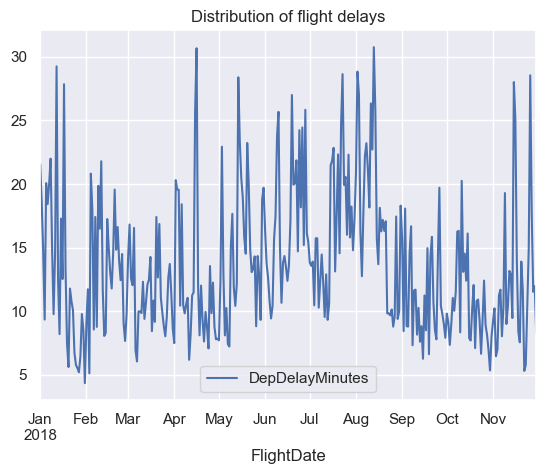

In [17]:
(df_flights
 .groupby("FlightDate")
 [["DepDelayMinutes"]]
 .mean()
 .plot(title="Distribution of flight delays"))


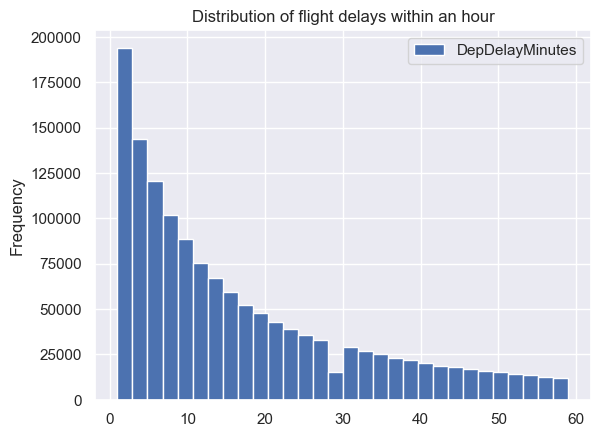

In [18]:
(df_flights
 .query("DepDelayMinutes > 0 and DepDelayMinutes < 60")
 [["DepDelayMinutes"]]
 .plot(kind="hist", bins=30, title="Distribution of flight delays within an hour"))
plt.show()


In [19]:
px.line(df_flights
        .groupby("FlightDate")
        [["DepDelayMinutes"]]
        .mean()
        )


#### Flight Status Categories

Departure Delay Groups

In [20]:
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[df_flights["Cancelled"], "DepDelayClass"] = "Cancelled"
    
DepDelay_Class(df_flights)

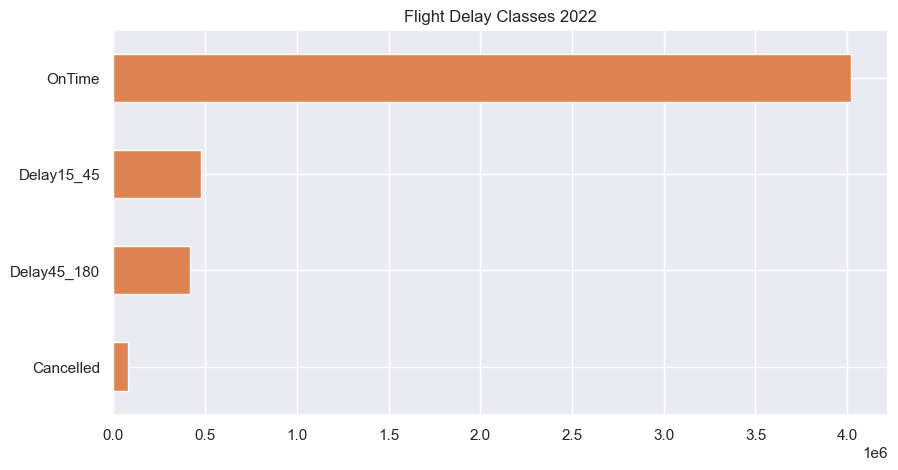

In [21]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes 2022")
 )
plt.show()

In [22]:
df_flights["DepDelayClass"].value_counts()/ df_flights.shape[0]

OnTime         0.804553
Delay15_45     0.095404
Delay45_180    0.084044
Cancelled      0.015999
Name: DepDelayClass, dtype: float64

In [23]:
df_flights["Year"] = df_flights["FlightDate"].dt.year
df_flights_agg = df_flights.groupby("Year")["DepDelayClass"].value_counts().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,79993,477018,420222,4022767


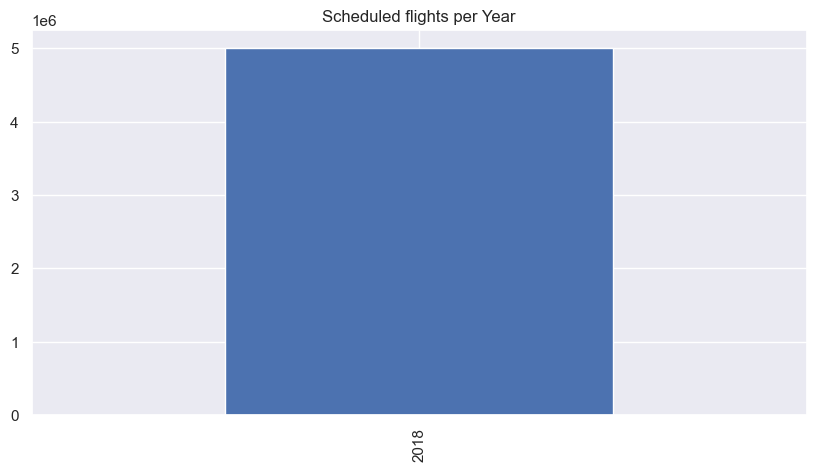

In [24]:
df_flights["Year"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per Year")
plt.show()

In [25]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.groupby("Month")["DepDelayClass"].value_counts().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,12690,41377,36486,367135
2,5149,29651,21728,211577
3,8939,34930,24404,277859
4,4778,44464,36471,397270
5,4350,37396,33610,274688
6,4306,36646,34320,242441
7,6215,40647,39149,281210
8,11669,52325,58284,381334
9,9503,48591,45437,534083


Flights per month

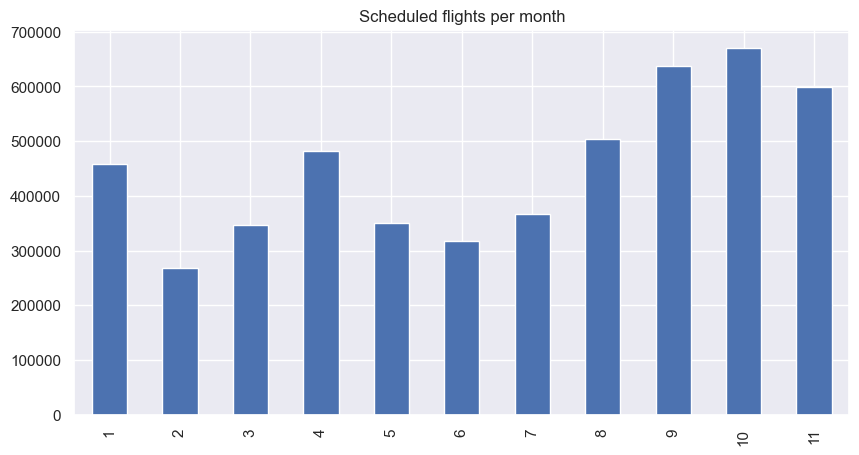

In [26]:
df_flights["Month"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per month")
plt.show()

In [27]:
df_flights_agg.sum(axis=1)


Month
1     457688
2     268105
3     346132
4     482983
5     350044
6     317713
7     367221
8     503612
9     637614
10    670090
11    598798
dtype: int64

In [28]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month
0,2018-01-23,Endeavor Air Inc.,N8928A,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1157.0,-5.0,0.0,0.0,1200-1259,14.0,1249.0,7.0,1304,1256.0,0.0,0.0,1300-1359,False,none,False,62.0,38.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1
1,2018-01-24,Endeavor Air Inc.,N800AY,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1157.0,-5.0,0.0,0.0,1200-1259,13.0,1246.0,12.0,1304,1258.0,0.0,0.0,1300-1359,False,none,False,62.0,36.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1
2,2018-01-25,Endeavor Air Inc.,N8836A,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1153.0,-9.0,0.0,0.0,1200-1259,18.0,1251.0,11.0,1304,1302.0,0.0,0.0,1300-1359,False,none,False,62.0,40.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1
3,2018-01-26,Endeavor Air Inc.,N800AY,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1150.0,-12.0,0.0,0.0,1200-1259,17.0,1242.0,11.0,1304,1253.0,0.0,0.0,1300-1359,False,none,False,62.0,35.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1
4,2018-01-27,Endeavor Air Inc.,N8839E,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1400,1355.0,-5.0,0.0,0.0,1400-1459,17.0,1448.0,11.0,1500,1459.0,0.0,0.0,1500-1559,False,none,False,60.0,36.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1


In [29]:
# Factors affecting delay
# Assumption: A flight is counted as "on time" if it operated less than 15 minutes later than the
def flight_status(df_flights):
        df_flights["FlightStatus"]="OnTime"

        df_flights.loc[df_flights["DepDel15"] == 0, "FlightStatus"]="OnTime"
        df_flights.loc[(df_flights["DepDelayMinutes"] >= 0) & (df_flights["DepDelayMinutes"] <= 15), "FlightStatus"]="OnTime"
        df_flights.loc[df_flights["WeatherDelay"] > 15, "FlightStatus"]="WeatherDelay"
        df_flights.loc[df_flights["NASDelay"] > 15, "FlightStatus"]="NASDelay"
        df_flights.loc[df_flights["SecurityDelay"] > 15, "FlightStatus"]="SecurityDelay"
        df_flights.loc[df_flights["LateAircraftDelay"] > 15, "FlightStatus"]="LateAircraftDelay"
        df_flights.loc[df_flights["CarrierDelay"] > 15, "FlightStatus"]="CarrierDelay"
        df_flights.loc[df_flights["Cancelled"], "FlightStatus"]="Cancelled"
    

flight_status(df_flights)


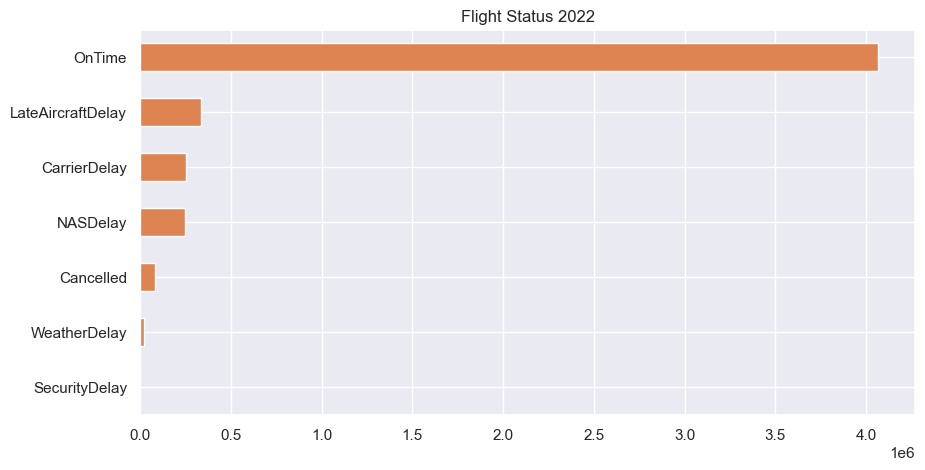

In [30]:
(df_flights
 .FlightStatus
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Status 2022")
 )
plt.show()

## Percentage of Flight results by Year

In [31]:
df_agg = (df_flights
 .groupby([df_flights["FlightDate"].dt.year, "Operating_Airline"])
 [["FlightStatus"]]
 .value_counts()
 .unstack()
 )
df_agg.style.background_gradient(cmap="Greens")

In [32]:
df_agg = (df_flights
 .groupby([df_flights["FlightDate"].dt.month, "Operating_Airline"])
 [["FlightStatus"]]
 .value_counts()
 .unstack()
 )
df_agg.style.background_gradient(cmap="Greens")

In [33]:
#df_flights.loc[df_flights["ArrTime"] == 0]

In [34]:
(df_flights["FlightStatus"].value_counts())/df_flights.shape[0]

OnTime               0.813430
LateAircraftDelay    0.066806
CarrierDelay         0.050461
NASDelay             0.049091
Cancelled            0.015999
WeatherDelay         0.003942
SecurityDelay        0.000272
Name: FlightStatus, dtype: float64

In [35]:
df_flights["FlightStatus"].value_counts()

OnTime               4067149
LateAircraftDelay     334029
CarrierDelay          252306
NASDelay              245456
Cancelled              79993
WeatherDelay           19709
SecurityDelay           1358
Name: FlightStatus, dtype: int64

In [36]:
df_flights.columns.to_list()

['FlightDate',
 'Operating_Airline',
 'Tail_Number',
 'Flight_Number',
 'OriginAirportID',
 'Origin',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestAirportID',
 'Dest',
 'DestCityName',
 'DestState',
 'DestStateName',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDel15',
 'DepDelayMinutes',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrTimeBlk',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CRSElapsedTime',
 'AirTime',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'FirstDepTime',
 'TotalAddGTime',
 'latitude',
 'longitude',
 'DepDelayClass',
 'Year',
 'Month',
 'FlightStatus']

In [37]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month,FlightStatus
0,2018-01-23,Endeavor Air Inc.,N8928A,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1157.0,-5.0,0.0,0.0,1200-1259,14.0,1249.0,7.0,1304,1256.0,0.0,0.0,1300-1359,False,none,False,62.0,38.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1,OnTime
1,2018-01-24,Endeavor Air Inc.,N800AY,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1157.0,-5.0,0.0,0.0,1200-1259,13.0,1246.0,12.0,1304,1258.0,0.0,0.0,1300-1359,False,none,False,62.0,36.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1,OnTime
2,2018-01-25,Endeavor Air Inc.,N8836A,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1153.0,-9.0,0.0,0.0,1200-1259,18.0,1251.0,11.0,1304,1302.0,0.0,0.0,1300-1359,False,none,False,62.0,40.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1,OnTime
3,2018-01-26,Endeavor Air Inc.,N800AY,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1150.0,-12.0,0.0,0.0,1200-1259,17.0,1242.0,11.0,1304,1253.0,0.0,0.0,1300-1359,False,none,False,62.0,35.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1,OnTime
4,2018-01-27,Endeavor Air Inc.,N8839E,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1400,1355.0,-5.0,0.0,0.0,1400-1459,17.0,1448.0,11.0,1500,1459.0,0.0,0.0,1500-1559,False,none,False,60.0,36.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1,OnTime


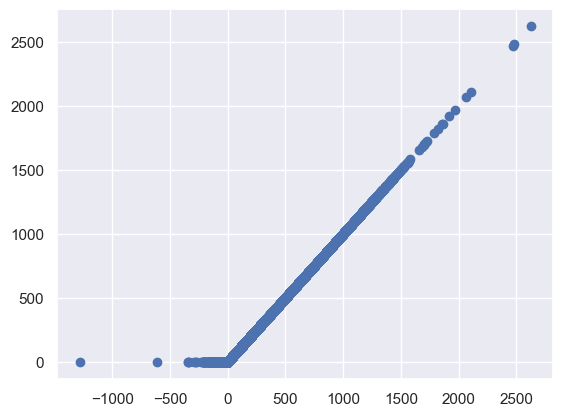

In [38]:
plt.scatter(df_flights["DepDelay"], df_flights["DepDelayMinutes"])

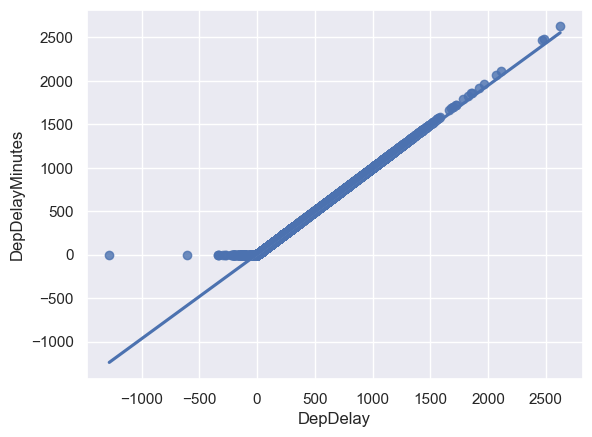

In [39]:
sns.regplot(x="DepDelay", y="DepDelayMinutes", data=df_flights)
plt.show()

In [40]:
(df_flights
 [["FlightStatus"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )

,Row Count
FlightStatus,
OnTime,4067149
LateAircraftDelay,334029
CarrierDelay,252306
NASDelay,245456
Cancelled,79993
WeatherDelay,19709
SecurityDelay,1358


#### Correlation [Pearson]

In [41]:
corr = (df_flights
        .select_dtypes('float16')
        .corr())
corr.style.background_gradient(cmap='coolwarm')


,DepTime,DepDelay,DepDel15,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,ArrTime,ArrDelayMinutes,ArrDel15,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime
DepTime,1.000000,0.143300,0.231148,0.138924,0.074743,0.679447,0.015780,0.657743,0.126437,0.194527,-0.011589,0.038858,-0.005313,0.037435,0.011052,0.055544,0.002847,0.132830,0.036843,0.018171
DepDelay,0.143300,1.000000,0.599098,0.996514,0.065698,0.041386,0.015438,0.034933,0.965602,0.544224,0.016274,0.013963,0.012227,0.629956,0.295223,0.348358,0.032755,0.636871,0.211972,0.219707
DepDel15,0.231148,0.599098,1.000000,0.579317,0.074639,0.118521,0.000951,0.110228,0.534097,0.744338,0.016904,0.021231,0.015415,0.281819,0.101694,0.227420,0.025385,0.420621,0.143314,0.115734
DepDelayMinutes,0.138924,0.996514,0.579317,1.000000,0.067841,0.038230,0.024016,0.032299,0.970124,0.527732,0.011337,0.010273,0.006395,0.636119,0.299263,0.347506,0.032658,0.638422,0.212159,0.221205
TaxiOut,0.074743,0.065698,0.074639,0.067841,1.000000,0.102306,0.070366,0.094460,0.186746,0.277847,0.096771,0.100812,0.054680,0.035629,0.057565,0.296586,0.000340,0.042905,0.019400,0.027206
WheelsOn,0.679447,0.041386,0.118521,0.038230,0.102306,1.000000,0.057336,0.966970,0.040220,0.106580,0.029538,0.083617,0.025971,0.002238,-0.000878,0.046555,0.001099,0.030710,-0.006770,-0.018345
TaxiIn,0.015780,0.015438,0.000951,0.024016,0.070366,0.057336,1.000000,0.057551,0.089465,0.120891,0.109263,0.111552,0.078071,0.008993,0.011587,0.168658,-0.000304,0.016550,0.000010,0.000955
ArrTime,0.657743,0.034933,0.110228,0.032299,0.094460,0.966970,0.057551,1.000000,0.034426,0.099384,0.022145,0.075886,0.018483,0.000122,-0.001555,0.042797,0.001019,0.025896,-0.008524,-0.019196
ArrDelayMinutes,0.126437,0.965602,0.534097,0.970124,0.186746,0.040220,0.089465,0.034426,1.000000,0.575179,0.007098,0.020817,0.002094,0.631710,0.308814,0.436172,0.032065,0.628139,0.200387,0.210530
ArrDel15,0.194527,0.544224,0.744338,0.527732,0.277847,0.106580,0.120891,0.099384,0.575179,1.000000,0.015967,0.045943,0.013398,0.284642,0.101681,0.368184,0.026351,0.416946,0.125337,0.099476


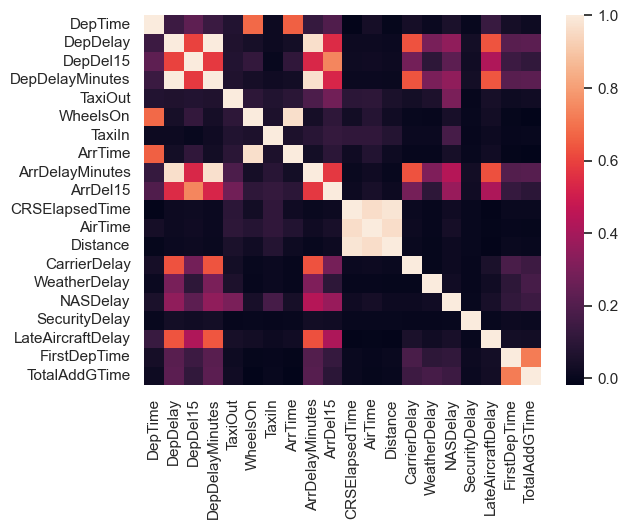

In [42]:
sns.heatmap(
    (df_flights
     .select_dtypes('float16')
     .corr()))
plt.show()


<AxesSubplot: xlabel='FlightDate'>

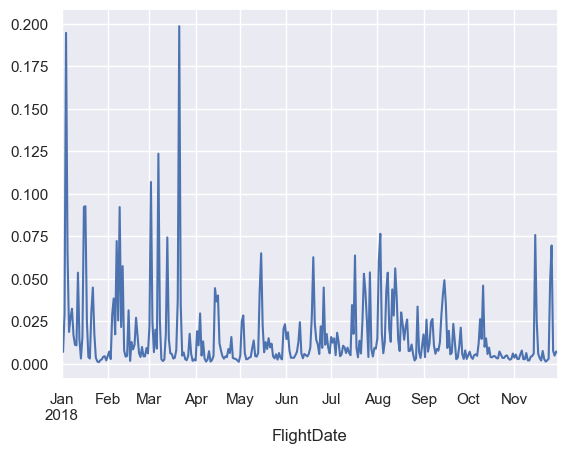

In [43]:
(df_flights.
 groupby("FlightDate")
 ["Cancelled"]
 .agg("mean")
 .plot()
 )


<AxesSubplot: xlabel='FlightDate'>

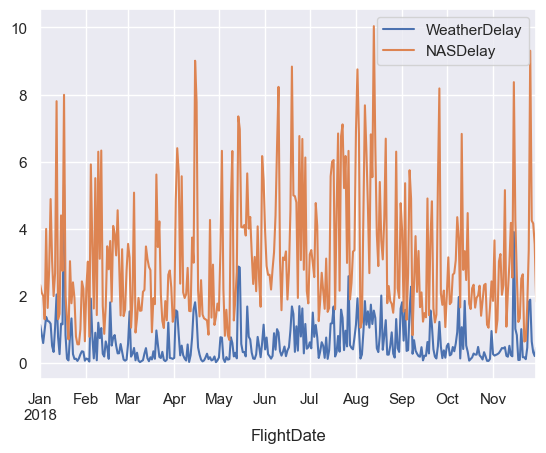

In [44]:
(df_flights.
 groupby("FlightDate")
 [["WeatherDelay", "NASDelay"]]
 .agg("mean")
 .plot())


<AxesSubplot: xlabel='FlightDate'>

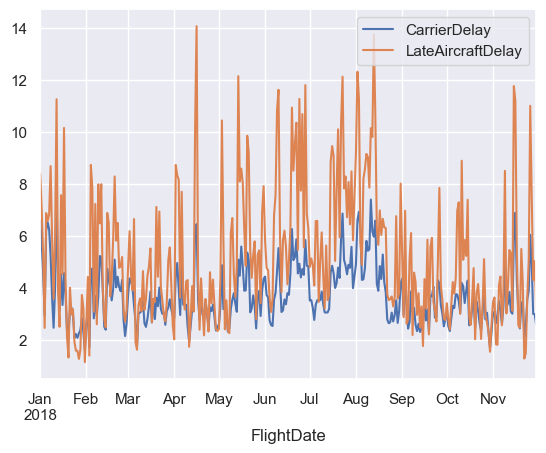

In [45]:
(df_flights.
 groupby("FlightDate")
 [["CarrierDelay", "LateAircraftDelay"]]
 .agg("mean")
 .plot())


##### Frequency Distribution Table

In [46]:
(df_flights
 [["Operating_Airline"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )


,Row Count
Operating_Airline,
Southwest Airlines Co.,1230564
United Air Lines Inc.,570035
SkyWest Airlines Inc.,467022
Delta Air Lines Inc.,381188
American Airlines Inc.,303537
JetBlue Airways,279660
Republic Airlines,177822
Alaska Airlines Inc.,162101
Spirit Air Lines,161165


In [47]:
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Flights per airline",
    height=700,
)


In [48]:
df_flights.head(3)

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month,FlightStatus
0,2018-01-23,Endeavor Air Inc.,N8928A,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1157.0,-5.0,0.0,0.0,1200-1259,14.0,1249.0,7.0,1304,1256.0,0.0,0.0,1300-1359,False,none,False,62.0,38.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1,OnTime
1,2018-01-24,Endeavor Air Inc.,N800AY,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1157.0,-5.0,0.0,0.0,1200-1259,13.0,1246.0,12.0,1304,1258.0,0.0,0.0,1300-1359,False,none,False,62.0,36.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1,OnTime
2,2018-01-25,Endeavor Air Inc.,N8836A,3298,10146,ABY,"Albany, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,1202,1153.0,-9.0,0.0,0.0,1200-1259,18.0,1251.0,11.0,1304,1302.0,0.0,0.0,1300-1359,False,none,False,62.0,40.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.535515,-84.194473,OnTime,2018,1,OnTime


In [49]:
(df_flights.
 groupby(["Flight_Number", "Tail_Number", "OriginCityName","DestCityName" ])
[["DepDelayMinutes"]]
#.agg(["mean", "sum"]).head(20)
)


In [50]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights
 .loc[df_flights["DepDelayMinutes"] >10, cols ]
 .sort_values(by=["Flight_Number", "FlightDate", "CRSDepTime"],ascending=[True, True, True]))

,FlightDate,Tail_Number,Flight_Number,Operating_Airline,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelayMinutes,AirTime,FlightStatus
262665,2018-01-01,N8536Z,1,Southwest Airlines Co.,"Dallas, TX","Houston, TX",700,731.0,31.0,43.0,CarrierDelay
329122,2018-01-01,N954JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1055,1127.0,32.0,181.0,LateAircraftDelay
117026,2018-01-02,N514AS,1,Alaska Airlines Inc.,"Washington, DC","Seattle, WA",800,813.0,13.0,321.0,OnTime
65170,2018-01-03,N8630B,1,Southwest Airlines Co.,"Dallas, TX","Houston, TX",700,711.0,11.0,47.0,OnTime
66498,2018-01-03,N8630B,1,Southwest Airlines Co.,"Chicago, IL","Nashville, TN",1705,1732.0,27.0,56.0,OnTime
186701,2018-01-04,N8611F,1,Southwest Airlines Co.,"Phoenix, AZ","Chicago, IL",1155,1206.0,11.0,175.0,OnTime
19019,2018-01-05,N390HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,711.0,11.0,338.0,OnTime
332508,2018-01-05,N966JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1000,1216.0,136.0,158.0,CarrierDelay
119071,2018-01-06,N597AS,1,Alaska Airlines Inc.,"Washington, DC","Seattle, WA",800,1022.0,142.0,317.0,CarrierDelay
235414,2018-01-06,N966JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1000,1232.0,152.0,171.0,CarrierDelay


In [51]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights[cols]
 .groupby(["Flight_Number", "Operating_Airline"])
 [["DepDelayMinutes"]]
 .mean())

DepDelayMinutes
Flight_Number Operating_Airline                                         
1             Air Wisconsin Airlines Corp                            NaN
              Alaska Airlines Inc.                              2.381743
              Allegiant Air                                          NaN
              American Airlines Inc.                            1.970874
              Cape Air                                               NaN
              Capital Cargo International                            NaN
              Comair Inc.                                            NaN
              Commutair Aka Champlain Enterprises, Inc.              NaN
              Compass Airlines                                       NaN
              Delta Air Lines Inc.                              8.428572
...                                                                  ...
9385          JetBlue Airways                                        NaN
              Mesa Airlines Inc.                                     NaN
              Peninsula Airways Inc.                                 NaN
              Republic Airlines                                42.000000
              SkyWest Airlines Inc.                                  NaN
              Southwest Airlines Co.                                 NaN
              Spirit Air Lines                                       NaN
              Trans States Airlines                                  NaN
              United Air Lines Inc.                                  NaN
              Virgin America                                         NaN

[200200 rows x 1 columns]

In [52]:
col2 = ["CarrierDelay","WeatherDelay",	"NASDelay",	"SecurityDelay","LateAircraftDelay", "FirstDepTime", "TotalAddGTime", "latitude", "longitude", "DepDelayClass"]
cols = ["FlightDate","CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]	